In [1]:
import sys
sys.path.append("../")

from smcdet.sampler import MHsampler
from smcdet.prior import M71Prior
from smcdet.images import M71ImageModel, generate_images

import torch

import matplotlib.pyplot as plt

import pickle

from utils.misc import select_cuda_device

device = select_cuda_device()
torch.cuda.set_device(device)
torch.set_default_device(device)

Selected device 0, which has 10822 MB available.


We generate an 8x8 image that emulates the M71 globular cluster:

In [2]:
with open('../experiments/m71/data/params.pkl', 'rb') as f:
    params = pickle.load(f)

params

{'flux_alpha': 0.21411753249015655,
 'flux_lower': 0.06291294097900389,
 'flux_upper': 1804.6791992187502,
 'flux_detection_threshold': 0.25165176391601557,
 'counts_rate': 0.030264640226960182,
 'background': 104.1486587524414,
 'adu_per_nmgy': 241.02658081054688,
 'psf_params': tensor([1.1072, 2.0800, 2.3254, 5.2406, 0.7347, 0.5115]),
 'psf_radius': 8,
 'noise_additive': 1.0000007072408224e-10,
 'noise_multiplicative': 1.936462640762329}

Number of stars (including undetectable and/or in padding): 8
Total intrinsic flux of stars (including undetectable and/or in padding): 38.790000915527344
Number of detectable stars within image boundary: 2
Total intrinsic flux of detectable stars within image boundary: 8.619999885559082
Total observed flux: 9487.75


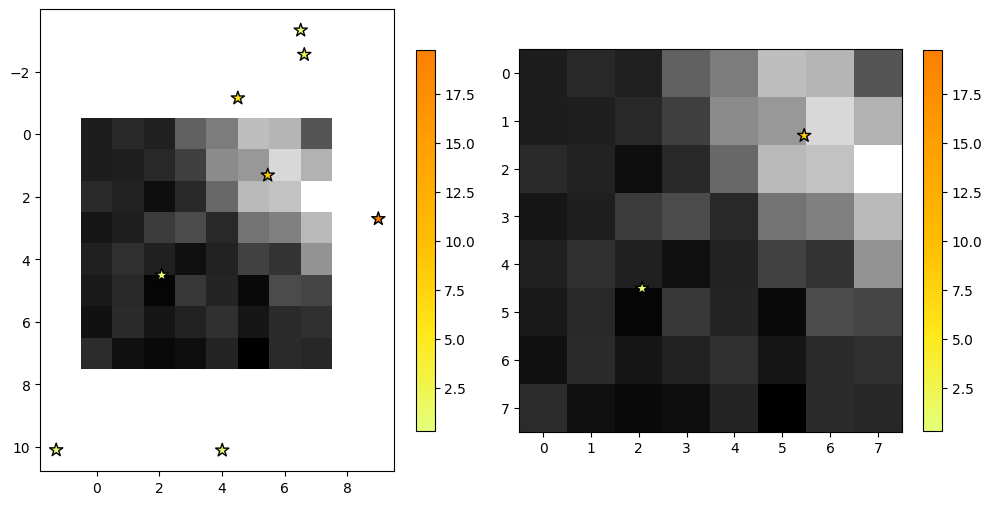

In [3]:
torch.manual_seed(0)

image_dim = 8

background = params["background"]
adu_per_nmgy = params["adu_per_nmgy"]
psf_params = params["psf_params"]
psf_radius = params["psf_radius"]
noise_additive = params["noise_additive"]
noise_multiplicative = params["noise_multiplicative"]

pad = 4

TruePrior = M71Prior(min_objects = 0,
                     max_objects = 100,
                     counts_rate = params["counts_rate"],
                     image_height = image_dim,
                     image_width = image_dim,
                     flux_alpha = params["flux_alpha"],
                     flux_lower = params["flux_detection_threshold"],
                     flux_upper = params["flux_upper"],
                     pad = pad)

TrueImageModel = M71ImageModel(image_height = image_dim,
                               image_width = image_dim,
                               background = background,
                               adu_per_nmgy = adu_per_nmgy,
                               psf_params = psf_params,
                               psf_radius = psf_radius,
                               noise_additive = noise_additive,
                               noise_multiplicative = noise_multiplicative)

res = generate_images(
    TruePrior,
    TrueImageModel,
    flux_threshold = params["flux_detection_threshold"],
    loc_threshold_lower = 0,
    loc_threshold_upper = image_dim,
    num_images = 1
)
unpruned_counts, unpruned_locs, unpruned_fluxes, pruned_counts, pruned_locs, pruned_fluxes, images = res

print(f'Number of stars (including undetectable and/or in padding): {unpruned_counts[0]}')
print(f'Total intrinsic flux of stars (including undetectable and/or in padding): {unpruned_fluxes[0].sum(-1).round(decimals=2)}')
print(f'Number of detectable stars within image boundary: {pruned_counts[0]}')
print(f'Total intrinsic flux of detectable stars within image boundary: {pruned_fluxes[0].sum(-1).round(decimals=2)}')
print(f'Total observed flux: {images[0].sum().round(decimals=2)}')

fig, ax = plt.subplots(1, 2, figsize = (12,6))

_ = ax[0].imshow(images[0].cpu(), cmap = 'gray')
stars = ax[0].scatter(unpruned_locs.squeeze()[:unpruned_counts.int().squeeze(),1].cpu() - 0.5,
                   unpruned_locs.squeeze()[:unpruned_counts.int().squeeze(),0].cpu() - 0.5,
                   c = unpruned_fluxes.squeeze()[:unpruned_counts.int().squeeze()].cpu(),
                   cmap = 'Wistia', marker = '*', edgecolors = 'black', s = 100)
_ = fig.colorbar(stars, fraction = 0.045)

_ = ax[1].imshow(images[0].cpu(), cmap = 'gray')
stars = ax[1].scatter(pruned_locs.squeeze()[:pruned_counts.int().squeeze(),1].cpu() - 0.5,
                   pruned_locs.squeeze()[:pruned_counts.int().squeeze(),0].cpu() - 0.5,
                   c = pruned_fluxes.squeeze()[:pruned_counts.int().squeeze()].cpu(),
                   vmin = unpruned_fluxes[unpruned_fluxes>0].min().cpu(),
                   vmax = unpruned_fluxes[unpruned_fluxes>0].max().cpu(),
                   cmap = 'Wistia', marker = '*', edgecolors = 'black', s = 100)
_ = fig.colorbar(stars, fraction = 0.045)

We will run the Metropolis-Hastings algorithm to generate catalogs for the entire image. We assume that we have access to the true prior and image model.

In [4]:
torch.set_default_device("cpu")

In [5]:
tile_dim = 8

TilePrior = M71Prior(min_objects = 10,
                     max_objects = 10,
                     counts_rate = params["counts_rate"],
                     image_height = tile_dim,
                     image_width = tile_dim,
                     flux_alpha = params["flux_alpha"],
                     flux_lower = params["flux_lower"],
                     flux_upper = params["flux_upper"],
                     pad = pad)

TileImageModel = M71ImageModel(image_height = tile_dim,
                               image_width = tile_dim,
                               background = background,
                               adu_per_nmgy = adu_per_nmgy,
                               psf_params = psf_params.cpu(),
                               psf_radius = psf_radius,
                               noise_additive = noise_additive,
                               noise_multiplicative = noise_multiplicative)

We initialize an `MHsampler` and run it on the tiles.

In [6]:
sampler = MHsampler(image = images[0].cpu(),
                    tile_dim = tile_dim,
                    Prior = TilePrior,
                    ImageModel = TileImageModel,
                    locs_stdev = 0.1,
                    fluxes_stdev = 2.5,
                    flux_detection_threshold = params["flux_detection_threshold"],
                    num_samples_total = 50000,
                    num_samples_burnin = 30000,
                    keep_every_k=2,
                    print_every=1000)

sampler.run()

iteration 1000, acceptance rate in past 1000 iters = 0.32

iteration 2000, acceptance rate in past 1000 iters = 0.29

iteration 3000, acceptance rate in past 1000 iters = 0.34

iteration 4000, acceptance rate in past 1000 iters = 0.34

iteration 5000, acceptance rate in past 1000 iters = 0.35

iteration 6000, acceptance rate in past 1000 iters = 0.32

iteration 7000, acceptance rate in past 1000 iters = 0.40

iteration 8000, acceptance rate in past 1000 iters = 0.40

iteration 9000, acceptance rate in past 1000 iters = 0.33

iteration 10000, acceptance rate in past 1000 iters = 0.36

iteration 11000, acceptance rate in past 1000 iters = 0.36

iteration 12000, acceptance rate in past 1000 iters = 0.29

iteration 13000, acceptance rate in past 1000 iters = 0.31

iteration 14000, acceptance rate in past 1000 iters = 0.33

iteration 15000, acceptance rate in past 1000 iters = 0.34

iteration 16000, acceptance rate in past 1000 iters = 0.30

iteration 17000, acceptance rate in past 1000 ite

We summarize our results by reporting the posterior distribution over the number of stars within the image boundaries and the posterior mean of the total intrinsic flux:

In [7]:
sampler.summarize()

posterior distribution of number of detectable stars within image boundary:
tensor([1, 2, 3])
tensor([0.8250, 0.1680, 0.0060]) 

posterior mean total intrinsic flux (including undetectable and/or in padding) = 70.7001724243164

posterior mean total intrinsic flux of detectable stars within image boundary = 8.624534606933594



We can examine the posterior predictive distribution of the total observed flux. The dotted black line is the true total observed flux, computed by summing the intensities of all the pixels in the image.

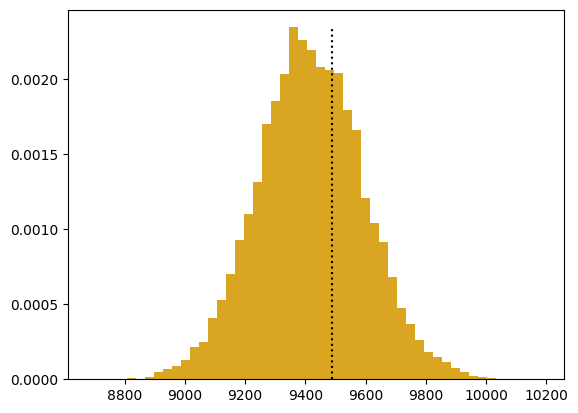

In [8]:
tmp = plt.hist(sampler.posterior_predictive_total_observed_flux.squeeze().cpu(), bins = 50, density = True, color = 'goldenrod')
_ = plt.vlines(x = images[0].sum().cpu(), ymin = 0, ymax = tmp[0].max(), color = 'black', linestyle = 'dotted')

We examine the posterior distribution of the total intrinsic flux of stars within the image boundary. The dotted black line is the ground truth. For images with stars near the boundary, this distribution will be multimodal. For each catalog, the total intrinsic flux within the boundary will depend on the locations of the stars near the boundary. We expect credible intervals based on this distribution to achieve nominal frequentist coverage in the limit of infinite samples, but some modes may not be characterized well unless the number of samples is large.

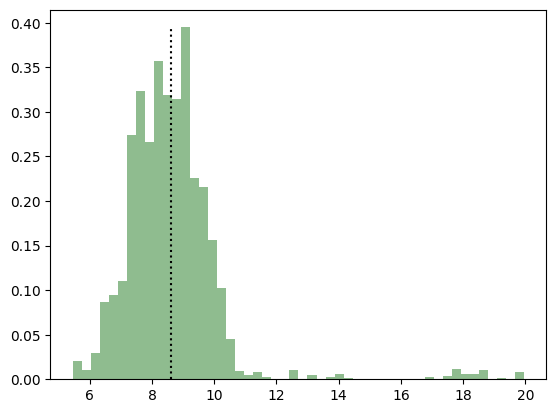

In [9]:
tmp = plt.hist(sampler.pruned_fluxes.squeeze().sum(-1).cpu(), bins = 50, density = True, color = 'darkseagreen')
_ = plt.vlines(x = pruned_fluxes.sum(-1).cpu(), ymin = 0, ymax = tmp[0].max(), color = 'black', linestyle = 'dotted')

We can also reconstruct the image using a few of our posterior catalogs. We plot the catalogs without applying the flux and location masks, so they include stars fainter than the detection threshold and/or outside the image boundary.

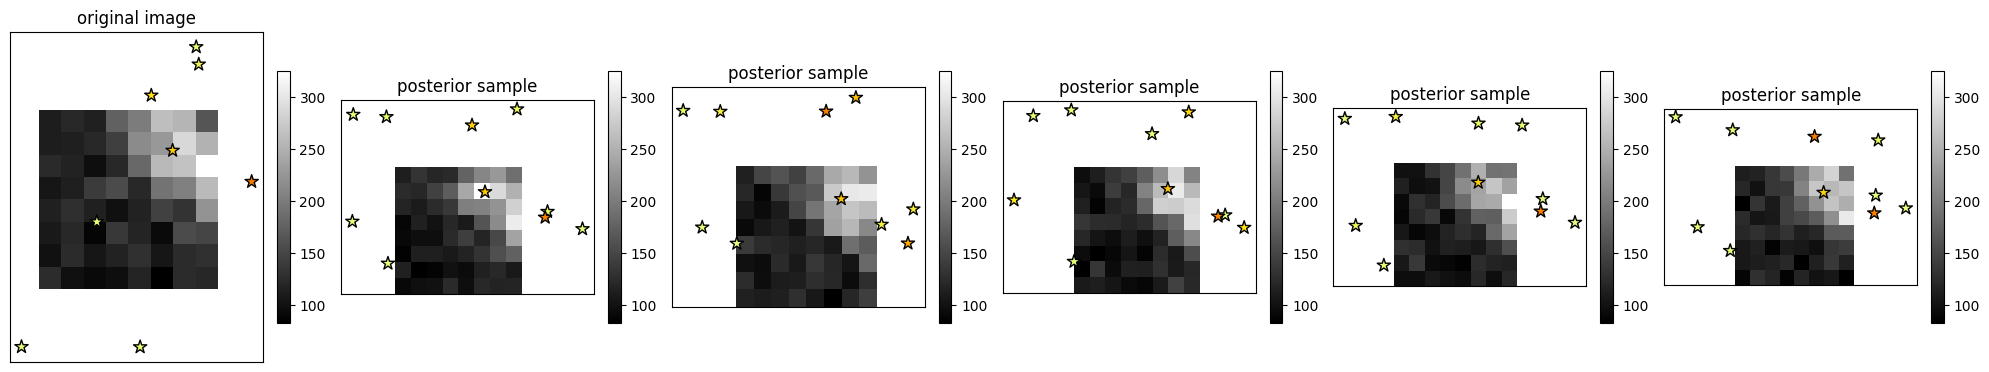

In [10]:
fig, ax = plt.subplots(1, 6, figsize = (20,4))

tmp = ax[0].imshow(images[0].cpu(), cmap = 'gray')
_ = fig.colorbar(tmp, fraction = 0.045)
_ = ax[0].set_title('original image')
_ = ax[0].scatter(unpruned_locs.squeeze()[:unpruned_counts.int().squeeze(),1].cpu() - 0.5,
                  unpruned_locs.squeeze()[:unpruned_counts.int().squeeze(),0].cpu() - 0.5,
                  c = unpruned_fluxes.squeeze()[:unpruned_counts.int().squeeze()].cpu(),
                  vmin = unpruned_fluxes[0][unpruned_fluxes[0]>0].min().cpu(),
                  vmax = unpruned_fluxes[0][unpruned_fluxes[0]>0].max().cpu(),
                  cmap = 'Wistia', marker = '*', edgecolors = 'black', s = 100)
_ = ax[0].set_xticks([])
_ = ax[0].set_yticks([])

for j in range(1,6):
    index = torch.randint(low = 0, high = sampler.counts.shape[-1] - 1, size = [1])
    psf = sampler.ImageModel.psf(sampler.locs[:,:,index])
    rate = (psf * params["adu_per_nmgy"] * sampler.fluxes[:,:,index].unsqueeze(-3).unsqueeze(-4)).sum(-1) + sampler.ImageModel.background
    reconstruction = torch.distributions.Normal(rate, (params["noise_additive"] + params["noise_multiplicative"] * rate).sqrt()).sample().squeeze([0,1]).permute((2,0,1))
    tmp = ax[j].imshow(reconstruction[0].cpu(), cmap = 'gray', vmin = images[0].cpu().min(), vmax = images[0].cpu().max())
    _ = ax[j].set_title('posterior sample')
    _ = fig.colorbar(tmp, fraction = 0.045)
    _ = ax[j].scatter(sampler.locs.squeeze()[index,:sampler.counts.squeeze()[index].int(),1].cpu() - 0.5,
                      sampler.locs.squeeze()[index,:sampler.counts.squeeze()[index].int(),0].cpu() - 0.5,
                      c = sampler.fluxes.squeeze()[index,:sampler.counts.squeeze()[index].int()].cpu(),
                      vmin = unpruned_fluxes[0][unpruned_fluxes[0]>0].min().cpu(),
                      vmax = unpruned_fluxes[0][unpruned_fluxes[0]>0].max().cpu(),
                      cmap = 'Wistia', marker = '*', edgecolors = 'black', s = 100)
    _ = ax[j].set_xticks([])
    _ = ax[j].set_yticks([])

fig.tight_layout()

To assess the locations of light sources in our posterior catalogs, we plot a two-dimensional density plot of the locations and overlay them on the image:

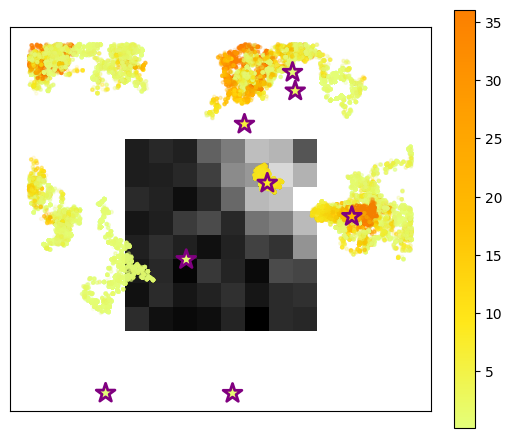

In [11]:
idx = torch.arange(0, sampler.locs.squeeze().shape[0])

fig, ax = plt.subplots(1, 1, figsize = (6, 6))
_ = ax.imshow(images[0].cpu(), cmap = 'gray')
_ = ax.scatter(sampler.locs.squeeze()[idx,...,1].cpu() - 0.5,
               sampler.locs.squeeze()[idx,...,0].cpu() - 0.5,
               c = sampler.fluxes.squeeze()[idx].cpu(),
               vmin = min(unpruned_fluxes[0][unpruned_fluxes[0]>0].min().cpu(), sampler.fluxes.squeeze()[idx][sampler.fluxes.squeeze()[idx]>0].quantile(0.05).cpu()),
               vmax = max(unpruned_fluxes[0][unpruned_fluxes[0]>0].max().cpu(), sampler.fluxes.squeeze()[idx][sampler.fluxes.squeeze()[idx]>0].quantile(0.95).cpu()),
               marker = '.', cmap = 'Wistia', s = 20, alpha = 0.1)
tmp = ax.scatter(unpruned_locs[0].squeeze()[:unpruned_counts[0].int(),1].cpu() - 0.5,
               unpruned_locs[0].squeeze()[:unpruned_counts[0].int(),0].cpu() - 0.5,
               c = unpruned_fluxes[0].squeeze()[:unpruned_counts[0].int()].cpu(),
               vmin = min(unpruned_fluxes[0][unpruned_fluxes[0]>0].min().cpu(), sampler.fluxes.squeeze()[idx][sampler.fluxes.squeeze()[idx]>0].quantile(0.05).cpu()),
               vmax = max(unpruned_fluxes[0][unpruned_fluxes[0]>0].max().cpu(), sampler.fluxes.squeeze()[idx][sampler.fluxes.squeeze()[idx]>0].quantile(0.95).cpu()),
               marker = '*', cmap = 'Wistia', edgecolors = 'purple', linewidth = 2, s = 200)
_ = fig.colorbar(tmp, fraction = 0.045)
_ = ax.set_xticks([])
_ = ax.set_yticks([])

We repeat the above after applying the location and flux thresholds:

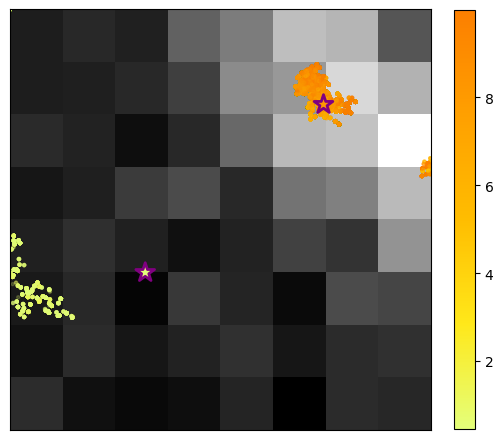

In [12]:
idx = torch.randint(0, sampler.locs.squeeze().shape[0], size = [25000])

fig, ax = plt.subplots(1, 1, figsize = (6, 6))
_ = ax.imshow(images[0].cpu(), cmap = 'gray')
_ = ax.scatter(sampler.pruned_locs.squeeze()[idx,...,1].cpu() - 0.5,
               sampler.pruned_locs.squeeze()[idx,...,0].cpu() - 0.5,
               c = sampler.pruned_fluxes.squeeze()[idx].cpu(),
               vmin = min(pruned_fluxes[0][pruned_fluxes[0]>0].min().cpu(), sampler.pruned_fluxes.squeeze()[idx][sampler.pruned_fluxes.squeeze()[idx]>0].quantile(0.05).cpu()),
               vmax = max(pruned_fluxes[0][pruned_fluxes[0]>0].max().cpu(), sampler.pruned_fluxes.squeeze()[idx][sampler.pruned_fluxes.squeeze()[idx]>0].quantile(0.95).cpu()),
               marker = '.', cmap = 'Wistia', s = 20, alpha = 0.2)
tmp = ax.scatter(pruned_locs[0].squeeze()[:pruned_counts[0].int(),1].cpu() - 0.5,
               pruned_locs[0].squeeze()[:pruned_counts[0].int(),0].cpu() - 0.5,
               c = pruned_fluxes[0].squeeze()[:pruned_counts[0].int()].cpu(),
               vmin = min(pruned_fluxes[0][pruned_fluxes[0]>0].min().cpu(), sampler.pruned_fluxes.squeeze()[idx][sampler.pruned_fluxes.squeeze()[idx]>0].quantile(0.05).cpu()),
               vmax = max(pruned_fluxes[0][pruned_fluxes[0]>0].max().cpu(), sampler.pruned_fluxes.squeeze()[idx][sampler.pruned_fluxes.squeeze()[idx]>0].quantile(0.95).cpu()),
               marker = '*', cmap = 'Wistia', edgecolors = 'purple', linewidth = 2, s = 200)
_ = fig.colorbar(tmp, fraction = 0.045)
_ = ax.set_xticks([])
_ = ax.set_yticks([])